# Direct Optimal Control Lecture and Demo

## Python Code Basics

Install the necessary packages

In [252]:
pip install numpy matplotlib casadi scipy

Note: you may need to restart the kernel to use updated packages.


In [253]:
from scipy.optimize import fsolve
from casadi import *
import matplotlib.pyplot as plt

## Illustrative Example

This is the model of an adsorption column for scrubbing ${CO}_2$ from air in a cabin.

Consider an isothermal adsorption bed with constant rate of generation of ${CO}_2$ in the cabin and constant rate of adsorption of ${CO}_2$ in the adsorber.

The dimensionless mass balances are:
$$
    \begin{aligned}
        \dot{x}_1 & = \frac{u_2}{V_1} x_2 - \frac{u_1}{V_1} x_1 + \frac{r_1}{V_1} \\
        \dot{x}_2 & = \frac{u_1}{V_2} x_1 - \frac{u_2}{V_2} x_2 - \frac{r_2}{V_2} \\
    \end{aligned}
$$

- $x_1$: $C_c$ concentration of ${CO}_2$ in the cabin
- $x_2$: $C_a$ concentration of ${CO}_2$ in the adsorber
- $u_1$: volumetric flow rate from cabin to adsorber
- $u_2$: volumetric flow rate from adsorber to cabin
- $V_1$: volume of the cabin
- $V_2$: volume of the adsorber
- $r_1$: rate of generation of ${CO}_2$ in the cabin
- $r_2$: rate of adsorption of ${CO}_2$ in the adsorber

In [254]:
def model(x, u, V, r):
    """Compute the right-hand side of the ODEs
    
    Args:
        x (array-like): State vector
        u (array-like): Input vector
        sigma (array-like): Parameters
    
    Returns:
        array-like: dx/dt    
    """
    dxdt = [0.] * 2
    dxdt[0] = (u[1]/V[0])*x[1] - (u[0]/V[0])*x[0] + (r[0]/V[0])
    dxdt[1] = (u[0]/V[1])*x[0] - (u[1]/V[1])*x[1] - (r[1]/V[1])

    return dxdt

In [273]:
# Get the steady-state
us = [30, 10]
V = [25, 0.4]
r = [150, 160]        # set to [0,0] for steady state values
f = lambda x: model(x, us, V, r)
xs, _, flag, _ = fsolve(f, [10, 10], full_output=True) # intial guess x1 = 5000, x2 = 5000 (ppCO2)

print(f'xs = {xs}')
print(f'Exit flag: {flag}')

xs = [ 5226.82494    15664.47507592]
Exit flag: 5


In [274]:
print(xs)
print(model(xs, us, V, r))

[ 5226.82494    15664.47507592]
[-0.39989762620825786, -0.006398361932951957]


## Direct Optimal Control Parameterizations

- Continuous-time optimal control problem:
$$
    \begin{aligned}
        & \min_{x(\cdot), ~u(\cdot)} && \int_0^T l_c(x(t), u(t))~dt + V_f(x(T)) \\
        & \quad\text{s.t.} && x(0) = x_0 \\
        &&& \dot{x}(t) = f(x(t), u(t)) & t\in [0,T] \\
        &&& h(x(t), u(t)) \leq 0 & t \in [0,T]
    \end{aligned}
$$
- Want to translate to:
$$
    \begin{aligned}
        & \min_{w \in \mathbb{R}^{n_w}} && F(w) \\
        & \quad\text{s.t.} && G(x_0, w) = 0 \\
        &&& H(w) \leq 0
    \end{aligned}
$$
- Discretization:
    1. Control trajectory (choose control parameterization)
    1. State trajectory (numerical integrator)
    1. Path constraints (impose at some grid points along time horizon)

### Direct Single Shooting

1. Parameterize control trajectory with a finite-dimensional vector $q \in \mathbb{R}^{n_q}$:
$$
    u(t) = \tilde{u}(t; q) ~\text{for}~ t \in [0, T]
$$

    - Example: $\tilde{u} : [0, T] \times \mathbb{R}^{n_q} \to \mathbb{R}^m$ is a polynomial of degree $p$; need to fit $(p+1)$ coefficients so $n_q = (p+1)m$
    - Usually, use a piecewise constant control parameterization (zeroth-order hold)
    - Divide $[0, T]$ into $N$ subintervals $[t_i, t_{i+1}]$ with $0 = t_0 < t_1 < \cdots < t_N = T$ ($\Delta = T/N$)
    $$
        \tilde{u}(t; q) = q_i ~\text{for}~t \in [t_i, t_{i+1})
    $$
    for $i = 0, \ldots, N-1$
    - Decision variable vector:
    $$
        q :=
        \begin{bmatrix}
            q_0 \\ q_1 \\ \vdots \\ q_{N-1}
        \end{bmatrix} \in \mathbb{R}^{n_q = Nm}
    $$
2. Numerical simulation to get $x(t)$:
$$
    \tilde{x}(t; x_0, q) ~\forall~t \in [0, T]
$$
    
    - To avoid, non-smooth RHS stop and restart integrator at each $t_i$, $i = 1, \ldots, N-1$ where $\tilde{x}(t_i; x_0, q)$ is both the initial state for the interval $[t_i, t_{i+1}]$ and final state for the interval $[t_{i-1}, t_i]$
    - Cost
        1. Add quadrature state
        $$
            \dot{x}_{quad}(t) = l_c(x(t), u(t))
        $$
        
        2. Refinement grid divide into $M$ equally sized subintervals: $[\tau_{i,j}, \tau_{i,j+1}]$ with $\tau_{i,j} := t_i +j/M(t_{i+1} - t_i)$, $j = 0, \ldots, M$, $i = 0, \ldots, N-1$. Reiman sum:
        $$
            F(x_0, q) := \sum_{i=0}^{N-1} \sum_{j = 0}^{M-1} l_c(\tilde{x}(\tau_{i,j}; x_0, q), \tilde{u}(\tau_{i,j}; q))(\tau_{i,j+1} - \tau_{i,j}) + V_f(\tilde{x}(T; x_0, q))
        $$
3. Discretization of path constraints (usually pick same grid as control discretization) and for simplicitiy of notation, define $h(\tau_{i,j}) := h(\tilde{x}(\tau_{i,j}; x_0, q), \tilde{u}(\tau_{i,j}; q))$
$$
    H(x_0, q) := \begin{bmatrix}
                    h(\tau_{0,0}) \\ h(\tau_{0,1}) \\ \vdots \\ 
                    h(\tau_{1,0}) \\ h(\tau_{1,1}) \\ \vdots \\ 
                    h(\tau_{N-1, M-1}) \\ h_f(\tilde{x}(T; x_0, q))
                 \end{bmatrix}
$$
where $h : \mathbb{R}^n \times \mathbb{R}^m \to \mathbb{R}^{n_h}$, $h_f : \mathbb{R}^n \to \mathbb{R}^{n_{h_f}}$ and $H : \mathbb{R}^n \times \mathbb{R}^{Nm} \to \mathbb{R}^{NMn_h + n_{h_f}}$

Resulting problem:
$$
    \begin{aligned}
        & \min_{s_0, q} && F(s_0, q) \\
        & ~~\text{s.t.} && s_0 - x_0 = 0 \\
        &&& H(s_0, q) \leq 0
    \end{aligned}
$$

### Aside - Integrators in CasADi

In [275]:
# CasADi works with symbolics
t = SX.sym("t", 1, 1)
x = SX.sym("x", 2, 1)
u = SX.sym("u", 2, 1)
ode = vertcat(*model(x, u, V, r))
print(ode, ode.shape)

@1=25, @2=0.4, [((((u_1/@1)*x_1)-((u_0/@1)*x_0))+6), ((((u_0/@2)*x_0)-((u_1/@2)*x_1))-400)] (2, 1)


In [276]:
# Parameters (used in optimal control problem later as well)
T = 2
N = 100
dt = T/N

Construct an intergrating block $x_{k+1} = \Phi(f; \Delta t; x_k, u_k)$

In [277]:
f = {'x': x, 't':t, 'p':u, 'ode':ode}
Phi = integrator("Phi", "cvodes", f, {'tf': dt})
# DM is mainly used for storing matrices in CasADi and as inputs/output of functions
initial_condition = DM([5000, 5000])
initial_condition_u = DM([30, 0.1])
print(Phi(x0=initial_condition))

{'qf': DM([]), 'rqf': DM([]), 'rxf': DM([]), 'rzf': DM([]), 'xf': DM([5000.12, 4992]), 'zf': DM([])}


In [278]:
# Integrate the model
x = initial_condition
history = [x]
for i in range(N):
    x = Phi(x0=x)["xf"]
    history.append(x)

Text(0.5, 0, 'time (hr)')

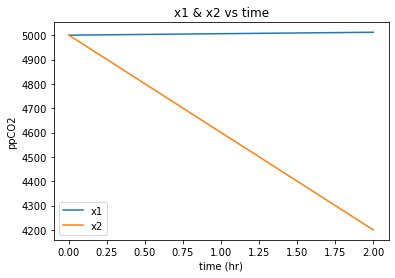

In [279]:
time = [i*dt for i in range(N+1)]
plt.plot(time, horzcat(*history).T)
plt.legend(['x1', 'x2'])
plt.title('x1 & x2 vs time')
plt.ylabel('ppCO2')
plt.xlabel('time (hr)')

### Example

$$
    \begin{aligned}
        & \min_{x(\cdot), ~u(\cdot)} && \int_0^T (x(t)-x_s)^TQ_c (x(t)-x_s) + (u(t)-u_s)^T R_c (u(t)-u_s) ~dt \\
        & \quad\text{s.t.} && x(0) = x_0 \\
        &&& \dot{x}_1 = \frac{u_2}{V_1} x_2 - \frac{u_1}{V_1} x_1 + \frac{r_1}{V_1} \\
        &&& \dot{x}_2 = \frac{u_1}{V_2} x_1 - \frac{u_2}{V_2} x_2 - \frac{r_2}{V_1} \\
        &&& \\
        &&& 0 \leq x_1(t) \leq 5000 \\
        &&& 0 \leq x_2(t) \leq 20000 \\   
        &&& 30 \leq u_1(t) \leq 50 \\
        &&& 0.1 \leq u_2(t) \leq 10,  t \in [0,T] \\
        &&& \\
        &&& r_1 = 150, r_2 = 160 \\
        &&& V_1 = 25, V_2 = 0.4 \\
        &&& \\
        &&& V(x) = \frac{1}{2} x^T x\\
        &&& \Rightarrow \dot{V}(x) = x^T \dot{x} = x^T \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} = x_1 \dot{x}_1 + x_2 \dot{x}_2 \\
        &&& \\
        &&& \Rightarrow \dot{V}(x) = \frac{u_2}{V_1} x_1 x_2 - \frac{u_1}{V_1} x_1^2 + \frac{u_1}{V_2} x_1 x_2 - \frac{u_2}{V_2} x_2^2 \\
        &&& \\
        &&& \Rightarrow \dot{V}(x) = (\frac{u_2}{V_1} + \frac{u_1}{V_2}) x_1 x_2 - (\frac{u_1}{V_1} + \frac{u_2}{V_2})(x_1^2 + x_2^2) \\
        &&& \\
        &&& \dot{V}(x) \leq 0 \\
    \end{aligned}
$$

In [280]:
# Define the decision variable vector
q=vertcat(*[MX.sym(f'x{i}',2,1) for i in range (N)]) 
print(q)
print(q.shape)

vertcat(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27, x28, x29, x30, x31, x32, x33, x34, x35, x36, x37, x38, x39, x40, x41, x42, x43, x44, x45, x46, x47, x48, x49, x50, x51, x52, x53, x54, x55, x56, x57, x58, x59, x60, x61, x62, x63, x64, x65, x66, x67, x68, x69, x70, x71, x72, x73, x74, x75, x76, x77, x78, x79, x80, x81, x82, x83, x84, x85, x86, x87, x88, x89, x90, x91, x92, x93, x94, x95, x96, x97, x98, x99)
(200, 1)


In [281]:
# Create the objective function (single shooting)
cost = 0.
Q = np.eye(2)*50
R = np.eye(2)*0.01

x_i = initial_condition
u_i = initial_condition_u
xss = DM(xs)
uss = DM(us)

for i in range(N):
    q_i = q[2*i:2*i+2,:]
    cost += (x_i-xss).T @ Q @ (x_i-xss) + (q_i-uss).T @ R @ (q_i-uss)
    x_i = Phi(x0=x_i, p=q_i)['xf']

Problem is transformed to (single shooting method):

$$
    \begin{aligned}
        & \min_{q \in \mathbb{R}^{2N}} && F(x_0, q) \\
        & \quad\text{s.t.} && q_{lb} \leq q \leq q_{ub}
    \end{aligned}
$$

In [282]:
# Create the optmization problem
lb=np.array([[30.],[0.1]]*N)
ub=np.array([[50.],[10.]]*N)
nlp={"x":q,"f":cost}
solver=nlpsol('solver','ipopt',nlp)
sol_out=solver(lbx=lb,ubx=ub)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    19704

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

In [283]:
# Compute the state trajectory
cost = 0.
u = np.zeros((N+1, 2))
x = np.zeros((N+1, 2))

x[0, :] = np.array(initial_condition).reshape(2)
x_i = initial_condition
x_i = initial_condition

for i in range(N):
    u_i = np.array(sol_out['x'][2*i:2*i+2, :]).T
    x_i = np.array(Phi(x0=x_i, p=u_i)['xf']).reshape((1,2))
   
    u[i, :] = u_i
    x[i+1, :] = x_i

# Append one extra for plotting
u[N, :] = u_i
print(x.shape)
print(u.shape)

(101, 2)
(101, 2)


<Figure size 1008x1008 with 0 Axes>

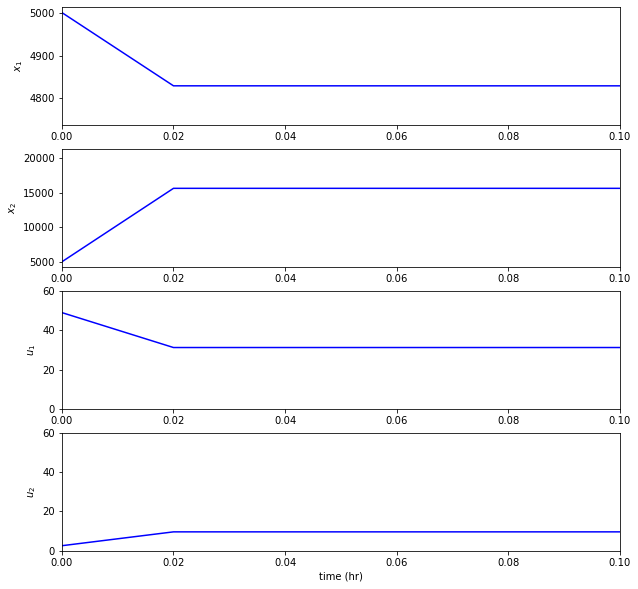

In [285]:
# Figure
plt.figure(figsize=[14, 14])
fig, axs = plt.subplots(4, 1, figsize=[10, 10])
t_max = 0.1
for j in range(2):
    axs[j].plot(time, x[:, j], 'b-')
    axs[j].set_ylabel(f'$x_{j+1}$')
    axs[j].set_xlim([0, t_max])

for j in range(2):
    axs[j+2].plot(time, u[:, j], 'b-')
    axs[j+2].set_ylabel(f'$u_{j+1}$')
    axs[j+2].set_xlim([0, t_max])
    axs[j+2].set_ylim([0, 60])
    axs[3].set_xlabel('time (hr)')

### Direct Multiple Shooting

1. Parameterize control trajectory with a finite-dimensional vector $q \in \mathbb{R}^{n_q}$:
    $$
        \tilde{u}(t; q) = q_i ~\text{for}~t \in [t_i, t_{i+1})
    $$
    for $i = 0, \ldots, N-1$
    - Decision variable vector:
    $$
        q :=
        \begin{bmatrix}
            q_0 \\ q_1 \\ \vdots \\ q_{N-1}
        \end{bmatrix} \in \mathbb{R}^{n_q = Nm}
    $$
2. Numerical simulation to get $x(t)$:
    - Same discretization choices, but keep
    $$
        s_i = x(t_i)
    $$
    as decision variables.
    - $N$ decoupled integrations
    $$
       \begin{aligned}
           \frac{d\tilde{x}_i}{dt}(t; s_i, q_i) & = f(\tilde{x}_i(t; s_i, q_i), q_i) && t \in [0, T]\\
           \tilde{x}_i(t_i; s_i, q_i) & = s_i
       \end{aligned}
    $$
    - Each piece only depends on $s_i$ and $q_i$
    - Using finer grid:
    $$
        l_i(s_i, q_i) = \sum_{j = 0}^{M-1} l_c(\tilde{x}(\tau_{i,j}; s_i, q_i)(\tau_{i,j+1}-\tau_{i,j})
    $$
3. Discretization of path constraints (usually pick same grid as control discretization) and for simplicitiy of notation, define $h(\tau_{i,j}) := h(\tilde{x}_i(\tau_{i,j}; s_i, q_i), q_i)$
$$
    H_i(s_i, q_i) := \begin{bmatrix}
                    h(\tau_{i,0}) \\ h(\tau_{i,1}) \\ \vdots \\ 
                    h(\tau_{i,M-1})
                 \end{bmatrix}
$$
where $h : \mathbb{R}^n \times \mathbb{R}^m \to \mathbb{R}^{n_h}$ and $H_i : \mathbb{R}^n \times \mathbb{R}^{m} \to \mathbb{R}^{Mn_h}$

Resulting problem:
$$
    \begin{aligned}
        & \min_{s, q} && \sum_{i=0}^{N-1} l_i(s_i, q_i) + V_f(s_N) \\
        & ~~\text{s.t.} && s_0 - x_0 = 0 \\
        &&& s_{i+1} = \tilde{x}_i(t_{i+1}; s_i, q_i) & i = 0, \ldots, N-1 \\
        &&& H_i(s_i, q_i) \leq 0 & i = 0, \ldots , N-1 \\
        &&& h_f(s_N) \leq 0
    \end{aligned}
$$

In [267]:
# Define the decision variable vector
q = vertcat(*[MX.sym(f'u{i}',2,1) for i in range(N)])
s = vertcat(*[MX.sym(f'x{i}',2,1) for i in range(N+1)])

z = []   # z = [s0,q0,s1,q1, ..., xN]
zlb = []
zub = []
constraints = []

# Create a function
cost = 0.             #initialize at 0

for i in range(N):
    s_i = s[2*i:2*(i+1)]
    s_ipl = s[2*(i+1):2*(i+2)]
    q_i = q[2*i:2*(i+1)]
    
    if i == 0:
        zlb += list(np.array(initial_condition).reshape(2))
        zub += list(np.array(initial_condition).reshape(2))
    else:
        zlb += [0., 0.]         # lower bound for concentration
        zub += [5000., 20000.]  # upper bound for concentration
    zlb += [30., 0.1]           # lower bound for flow rate control
    zub += [50., 10.]           # upper bound for flow rate control
    
    z.append(s_i)
    z.append(q_i)

    # Integrate
    xt_ipl = Phi(x0=s_i, p=q_i)['xf']
    # Create continuity constraints
    constraints.append(xt_ipl - s_ipl)
    # added to cost
    cost += (s_i - xss).T @ Q @ (s_i - xss) + (q_i - uss).T @ R @ (q_i - uss)
    
# Last element sN
z.append(s_ipl)
zlb += [0., 0.]         # lower bound for concentration
zub += [5000., 20000.]  # upper bound for concentration
    
constraints = vertcat(*constraints)
variables = vertcat(*z)
print(constraints.shape)
print(variables.shape)

(200, 1)
(402, 1)


In [268]:
# Create the optimization problem
g_bnd = np.zeros(N*2)
nlp = {'f':cost, 'g':constraints, 'x':variables}
solver = nlpsol('solver','ipopt',nlp)
sol_out = solver(lbx=zlb, ubx=zub, lbg=g_bnd, ubg=g_bnd)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      993

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

In [269]:
# Get the solution (x and u trajectories)
x = [[float(sol_out['x'][4*i+j]) for j in range(2)] for i in range(N+1)]
u = [[float(sol_out['x'][4*i+2+j]) for j in range(2)] for i in range(N)]
u.append(u[-1])

x = np.array(x)
u = np.array(u)

print(x.shape)
print(u.shape)


(101, 2)
(101, 2)


<Figure size 1008x1008 with 0 Axes>

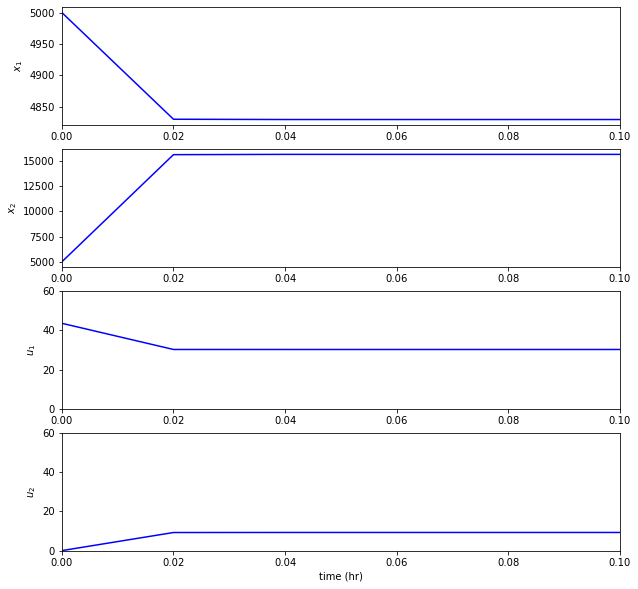

In [272]:
# Figure
plt.figure(figsize=[14, 14])
fig, axs = plt.subplots(4, 1, figsize=[10, 10])
t_max = 0.1
for j in range(2):
    axs[j].plot(time, x[:, j], 'b-')
    axs[j].set_ylabel(f'$x_{j+1}$')
    axs[j].set_xlim([0, t_max])

for j in range(2):
    axs[j+2].plot(time, u[:, j], 'b-')
    axs[j+2].set_ylabel(f'$u_{j+1}$')
    axs[j+2].set_ylim([0, 60])
    axs[j+2].set_xlim([0, t_max])
    axs[3].set_xlabel('time (hr)')